In [28]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from scipy.sparse import csr_matrix
from scipy.special import logsumexp, expit
import time
import matplotlib.pyplot as plt
from scipy import sparse
from matplotlib.ticker import MaxNLocator

In [29]:
class BaseSmoothOracle:

    def func(self, w):
        if(sparse.issparse(self.X)):
            if(w.ndim == 1):
                return np.sum(logsumexp(
                    np.vstack((
                            -1 * np.asarray(self.X.dot(w)) * self.y,
                            np.zeros(np.size(self.y))
                            )).T,
                    axis=1
                    )) / np.size(self.y) + self.l2_coef * np.dot(w, w) / 2
            else:
                max_val = np.amax(np.asarray(self.X.dot(w.T)), axis=1)
                return -1 * np.sum(
                    np.squeeze(np.asarray(
                            self.X.multiply(w[self.y.astype(int)]).sum(axis=1)), axis=1) -
                    max_val -
                    logsumexp(
                            np.asarray(self.X.dot(w.T)) -
                            max_val[:, np.newaxis],
                            axis=1)
                    ) / np.size(self.y) + self.l2_coef * np.sum(w * w) / 2
        else:
            if(w.ndim == 1):
                return np.sum(logsumexp(
                        np.vstack((
                                -1 * np.dot(self.X, w) * self.y,
                                np.zeros(np.size(self.y))
                                )).T,
                        axis=1
                        )) / np.size(self.y) + self.l2_coef * np.dot(w, w) / 2
            else:
                max_val = np.amax(np.dot(self.X, w.T), axis=1)
                return -1 * np.sum(
                        np.sum(self.X * w[self.y.astype(int)], axis=1) - max_val -
                        logsumexp(
                                np.dot(self.X, w.T) -
                                max_val[:, np.newaxis],
                                axis=1)
                        ) / np.size(self.y) + self.l2_coef * np.sum(w * w) / 2

    def grad(self, w):
        if(self.X.dtype == int):
            min_val = np.iinfo(self.X.dtype).min
            max_val = np.iinfo(self.X.dtype).max
        elif(self.X.dtype == float):
            min_val = np.finfo(self.X.dtype).min
            max_val = np.finfo(self.X.dtype).max
        if(sparse.issparse(self.X)):
            if(w.ndim == 1):
                arg = np.asarray(self.X.dot(w)) * self.y
                return np.squeeze(np.asarray(
                    self.X.multiply(self.y[:, np.newaxis]).multiply(
                        -1 * (np.clip(
                                    np.exp(-1 * arg),
                                    min_val, max_val
                            ) * expit(arg))[:, np.newaxis]
                    ).sum(axis=0)), axis=0) / \
                    np.size(self.y) + self.l2_coef * w
            else:
                mask = np.arange(np.size(w, 0))
                mask = mask[:, np.newaxis] == self.y[np.newaxis, :]
                max_arg = np.amax(np.asarray(self.X.dot(w.T)), axis=1)
                arg = np.asarray(self.X.dot(w.T)) - max_arg[:, np.newaxis]
                return self.X.transpose().dot( 
                    -1 * mask.T +
                    np.clip(np.exp(arg), min_val, max_val) /
                    np.clip(
                        np.sum(np.exp(arg), axis=1),
                        min_val, max_val)[:, np.newaxis]
                ).T / np.size(self.y) + self.l2_coef * w
        else:
            if(w.ndim == 1):
                arg = np.dot(self.X, w) * self.y
                return np.sum(
                        -1 * (np.clip(
                                np.exp(-1 * arg),
                                min_val, max_val
                        ) * expit(arg))[:, np.newaxis] *
                        self.X * self.y[:, np.newaxis],
                        axis=0
                        ) / np.size(self.y) + self.l2_coef * w
            else:
                mask = np.arange(np.size(w, 0))
                mask = mask[:, np.newaxis] == self.y[np.newaxis, :]
                max_arg = np.amax(np.dot(self.X, w.T), axis=1)
                arg = np.dot(self.X, w.T) - max_arg[:, np.newaxis]
                return np.dot(
                    self.X.T, 
                    -1 * mask.T + 
                    np.clip(np.exp(arg), min_val, max_val) /
                    np.clip(
                        np.sum(np.exp(arg), axis=1),
                        min_val, max_val
                    )[:, np.newaxis]).T / np.size(self.y) + self.l2_coef * w

class BinaryLogistic(BaseSmoothOracle):

    def __init__(self, l2_coef):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        self.X = X
        self.y = y
        return super().func(w)

    def grad(self, X, y, w):
        self.X = X
        self.y = y
        return super().grad(w)


class MulticlassLogistic(BaseSmoothOracle):

    def __init__(self, l2_coef):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        self.X = X
        self.y = y
        return super().func(w)

    def grad(self, X, y, w):
        self.X = X
        self.y = y
        return super().grad(w)


In [30]:
class GDClassifier:

    def __init__(self, loss_function, step_alpha=0.1, step_beta=1,
                 tolerance=1e-5, max_iter=1000, **kwargs):
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs

    def fit(self, X, y, X_test=np.zeros(1), y_test=np.zeros(1), w_0=None, trace=False):
        if(self.loss_function == 'binary_logistic'):
            if(w_0 is None):
                w_0 = np.zeros(np.size(X, 1))
            self.lr = BinaryLogistic(**self.kwargs)
        elif(self.loss_function == 'multinomial_logistic'):
            if(w_0 is None):
                w_0 = np.zeros((np.size(np.unique(y)), np.size(X, 1)))
            self.lr = MulticlassLogistic(**self.kwargs)
        self.w = w_0.copy()
        last_func = self.lr.func(X, y, self.w)
        curr_func = last_func
        if(trace):
            self.history = dict()
            self.history['time'] = [0.0]
            self.history['func'] = [last_func]
            self.history['acc'] = [np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test)]
            start = time.time()
        num_iter = 0
        while(num_iter == 0 or
              (np.abs(curr_func - last_func) >= self.tolerance and
               num_iter < self.max_iter)):
            num_iter += 1
            self.w -= self.lr.grad(X, y, self.w) * \
                self.step_alpha / num_iter ** self.step_beta
            last_func = curr_func
            curr_func = self.lr.func(X, y, self.w)
            if(trace):
                end = time.time()
                self.history['time'].append(end - start)
                self.history['func'].append(curr_func)
                self.history['acc'].append(np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test))
        if(trace):
            return self.history

    def predict(self, X):
        if(self.loss_function == 'binary_logistic'):
            if(sparse.issparse(X)):
                return np.sign(np.asarray(X.dot(self.w.T)))
            else:
                return np.sign(np.dot(X, self.w.T))
        else:
            if(sparse.issparse(X)):
                return np.argmax(np.asarray(X.dot(self.w.T)), axis=1)
            else:
                return np.argmax(np.dot(X, self.w.T), axis=1)

    def predict_proba(self, X):
        if(self.loss_function == 'binary_logistic'):
            if(sparse.issparse(X)):
                return expit(np.asarray(X.dot(self.w.T)))
            else:
                return expit(np.dot(X, self.w.T))
        elif(self.loss_function == 'multinomial_logistic'):
            if(sparse.issparse(X)):
                softmax = np.exp(np.asarray(X.dot(self.w.T)) -
                                 np.amax(
                                         np.asarray(X.dot(self.w.T)),
                                         axis=1
                                         )[:, np.newaxis]
                                 )
            else:
                softmax = np.exp(np.dot(X, self.w.T) -
                                 np.amax(
                                         np.dot(X, self.w.T),
                                         axis=1
                                         )[:, np.newaxis]
                                 )
            return softmax / np.sum(softmax, axis=1)[:, np.newaxis]

    def get_objective(self, X, y):
        return self.lr.func(X, y, self.w)

    def get_gradient(self, X, y):
        return self.lr.grad(X, y, self.w)

    def get_weights(self):
        return self.w


class SGDClassifier(GDClassifier):

    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0,
                 tolerance=1e-5, max_iter=100000, random_seed=153, **kwargs):
        GDClassifier.__init__(self, loss_function=loss_function, step_alpha=step_alpha, step_beta=step_beta,
                             tolerance=tolerance, max_iter=max_iter, **kwargs)
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.kwargs = kwargs

    def fit(self, X, y, X_test, y_test, w_0=None, trace=False, log_freq=1):
        np.random.seed(self.random_seed)
        if(self.loss_function == 'binary_logistic'):
            if(w_0 is None):
                w_0 = np.zeros(np.size(X, 1))
            self.lr = BinaryLogistic(**self.kwargs)
        elif(self.loss_function == 'multinomial_logistic'):
            if(w_0 is None):
                w_0 = np.zeros((np.size(np.unique(y)), np.size(X, 1)))
            self.lr = MulticlassLogistic(**self.kwargs)
        self.w = w_0.copy()
        last_func = self.lr.func(X, y, self.w)
        curr_func = last_func
        if(trace):
            self.history = dict()
            self.history['epoch_num'] = [0.0]
            self.history['time'] = [0.0]
            self.history['func'] = [last_func]
            self.history['weights_diff'] = [0.0]
            self.history['acc'] = [np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test)]
            start = time.time()
            last_epoch_num = 0
            curr_epoch_num = 0
            last_w = self.w.copy()
            curr_w = last_w.copy()
        num_iter = 0
        ind_list = np.arange(np.size(X, 0))
        np.random.shuffle(ind_list)
        curr_ind = 0
        while(num_iter == 0 or
              (np.abs(curr_func - last_func) >= self.tolerance and
               num_iter < self.max_iter)):
            if(curr_ind >= np.size(X, 0)):
                np.random.shuffle(ind_list)
                curr_ind = 0
            num_iter += 1
            self.w -= self.lr.grad(
                    X[curr_ind:curr_ind + self.batch_size, :], 
                    y[curr_ind:curr_ind + self.batch_size], self.w
                    ) * self.step_alpha / num_iter ** self.step_beta
            last_func = curr_func.copy()
            curr_func = self.lr.func(X, y, self.w)
            if(trace):
                if(curr_ind  + self.batch_size >= np.size(ind_list)):
                    curr_epoch_num += (np.size(ind_list) - curr_ind) / \
                        np.size(ind_list)
                else:
                    curr_epoch_num += self.batch_size / np.size(ind_list)
                if(curr_epoch_num - last_epoch_num >= log_freq):
                    end = time.time()
                    last_w = curr_w.copy()
                    curr_w = self.w
                    self.history['epoch_num'].append(curr_epoch_num)
                    self.history['time'].append(end - start)
                    self.history['func'] .append(curr_func)
                    self.history['acc'].append(np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test))
                    self.history['weights_diff'].append(
                            np.sum(
                                    (last_w - curr_w) ** 2, 
                                    axis=-1))
                    last_epoch_num = curr_epoch_num
            curr_ind += self.batch_size
        if(trace):
            return self.history
        
    def predict(self, X):
        return super().predict(X)

In [31]:
class MulticlassStrategy:   
    def __init__(self, classifier, mode, **kwargs):
        self.classifier = classifier
        self.mode = mode
        self.kwargs = kwargs
        pass
        
        
    def fit(self, X, y):
        self.num_classes = np.size(np.unique(y))
        if(self.mode == 'one_vs_all'):
            self.w = np.zeros((self.num_classes, X.shape[1]))
            for i in range(self.num_classes):
                mask = y == i
                curr_y = 2 * mask - 1 # 1 if y == i, -1 if not
                curr_lr = self.classifier(**self.kwargs)
                curr_lr.fit(X, curr_y)
                self.w[i] = curr_lr.get_weights()
        elif(self.mode == 'all_vs_all'):
            self.w = np.zeros((self.num_classes * (self.num_classes - 1) // 2, 
                              X.shape[1]))
            num = 0
            i_list = []
            j_list = []
            for i in range(self.num_classes - 1):
                for j in range(i + 1, self.num_classes):
                    i_list.append(i)
                    j_list.append(j)
                    matr_i = y == i
                    matr_j = y == j
                    matr = np.logical_or(matr_i, matr_j)
                    curr_x = X[matr]
                    curr_y = y.copy()
                    curr_y[matr_i] = 1
                    curr_y[matr_j] = -1
                    curr_y = curr_y[matr]
                    curr_lr = self.classifier(**self.kwargs)
                    curr_lr.fit(curr_x, curr_y)
                    self.w[num] = curr_lr.get_weights() 
                    num += 1
            self.i_arr = np.array(i_list)
            self.j_arr = np.array(j_list)
        
    def predict(self, X):
        if(self.mode == 'one_vs_all'):
            if(sparse.issparse(X)):
                return np.argmax(np.asarray(X.dot(self.w.T)), axis=1)
            else:
                return np.argmax(np.dot(X, self.w.T), axis=1)
        elif(self.mode == 'all_vs_all'):
            if(sparse.issparse(X)):
                pred = np.asarray(X.dot(self.w.T))
            else:
                pred = np.dot(X, self.w.T)
            mask = pred > 0
            self.i_arr = np.broadcast_to(self.i_arr, pred.shape)
            self.j_arr = np.broadcast_to(self.j_arr, pred.shape)
            pred[mask] = self.i_arr[mask]                            
            mask = np.logical_not(mask)
            pred[mask] = self.j_arr[mask]
            return np.argmax(np.apply_along_axis(
                lambda a:np.bincount(a, minlength=self.num_classes), 
                -1, pred.astype(int)), axis=1)

предобработка данных

In [32]:
with open('/home/daria/contests/task2/data_sentiment_news/news_test.json') as data_file:    
    test = pd.read_json(data_file)
with open('/home/daria/contests/task2/data_sentiment_news/news_train.json') as data_file:    
    train = pd.read_json(data_file)

In [33]:
x_test = test['text'].values
x_train = train['text'].values
y_test = test['sentiment'].values
y_train = train['sentiment'].values

In [38]:
for i in range(np.size(x_test)):
    x_test[i] = x_test[i].lower()
    x_test[i] = re.sub('[^0-9а-я]+', ' ', x_test[i])
for i in range(np.size(x_train)):
    x_train[i] = x_train[i].lower()
    x_train[i] = re.sub('[^0-9а-я]+', ' ', x_train[i])

In [39]:
mask_test = (y_test == 'positive') + (y_test == 'negative')
y_test_bin = y_test[mask_test]
x_test_bin = x_test[mask_test]
mask_train = (y_train == 'positive') + (y_train == 'negative')
y_train_bin = y_train[mask_train]
x_train_bin = x_train[mask_train]

y_train_bin = np.ones(np.size(y_train_bin)) - 2 *(y_train_bin == 'negative')
y_test_bin = np.ones(np.size(y_test_bin)) - 2 *(y_test_bin == 'negative')
#y_test_bin = y_test_bin == 'positive'

In [40]:
vectorizer = CountVectorizer(min_df=0.1)
x_train_bin = vectorizer.fit_transform(x_train_bin)
x_test_bin = vectorizer.transform(x_test_bin)

параметр step_beta

In [391]:
beta_list = [0.1 * x for x in range(6, 14)]
hist_list=[]
final_acc_list = []

for beta in beta_list:
    lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=beta, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))
    final_acc_list.append(np.sum(np.equal(y_test_bin, lr.predict(x_test_bin))) / np.size(y_test_bin))

In [392]:
final_acc_list

[0.662992125984252,
 0.721259842519685,
 0.7606299212598425,
 0.7543307086614173,
 0.8283464566929134,
 0.8047244094488188,
 0.8031496062992126,
 0.8031496062992126]

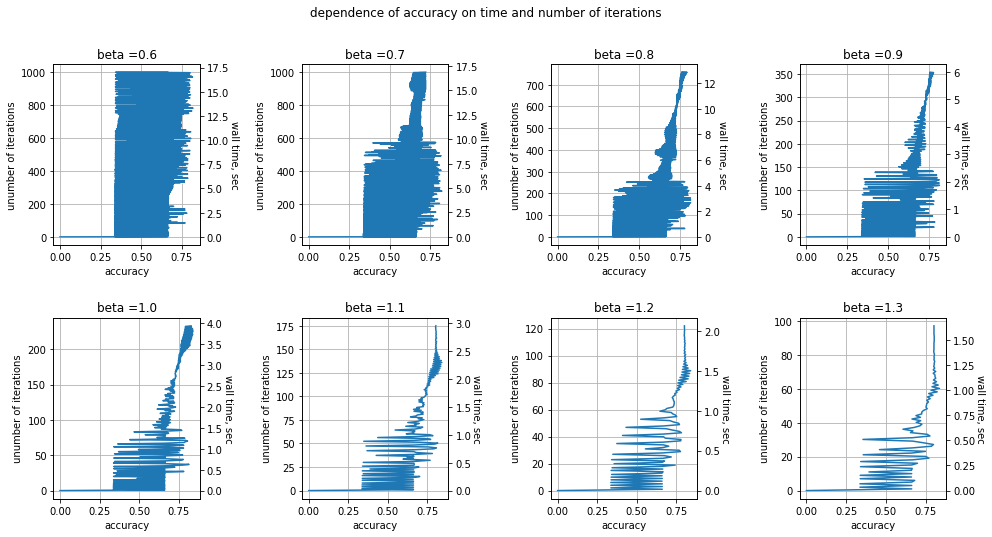

In [397]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of accuracy on time and number of iterations')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['acc'], np.arange(len(hist_list[i]['acc'])), c='w')
    axes1.set_title('beta =' + '%.1f' % beta_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('unumber of iterations')
    axes1.grid(True)
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['acc'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    num += 1
plt.savefig('beta_time_acc.pdf', bbox_inches='tight')

In [394]:
for i in range(len(hist_list)):
    print(hist_list[i]['func'][-1])

4.113872107049389
0.9886702255217904
0.6385484591425562
0.6472297801248409
0.5785559895369796
0.5531555363689306
0.5531894003982194
0.5532100998765763


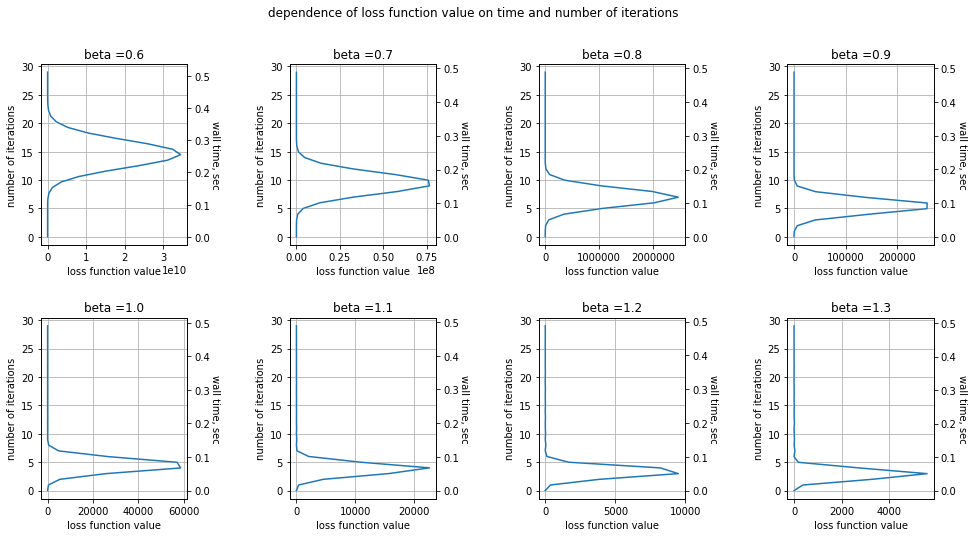

In [395]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function value on time and number of iterations')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'][:30], np.arange(len(hist_list[i]['func'][:30])), c='w')
    axes1.set_title('beta =' + '%.1f' % beta_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of iterations')
    axes1.grid(True)
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'][:30], hist_list[i]['time'][:30])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    num += 1
plt.savefig('beta_time_func_1.pdf', bbox_inches='tight')

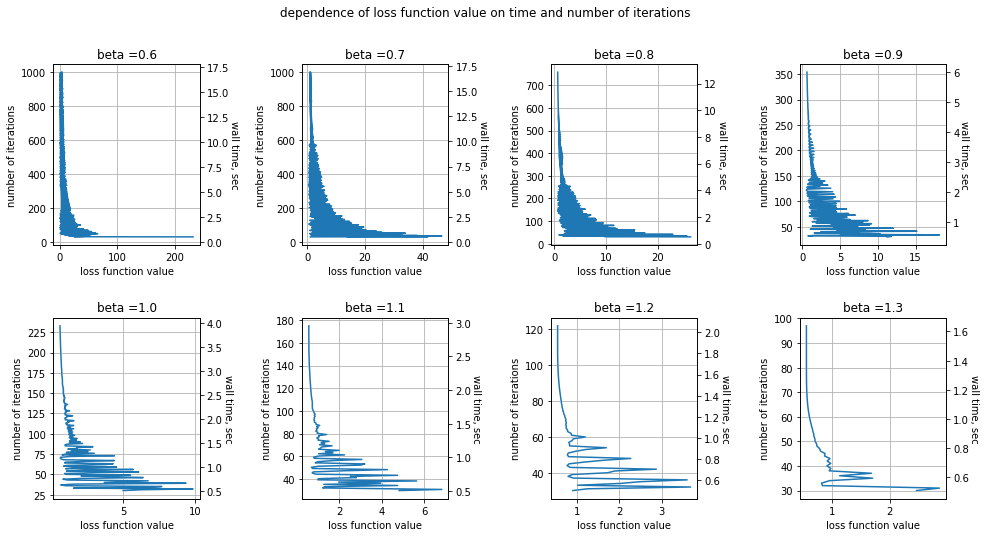

In [396]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function value on time and number of iterations')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'][30:], np.arange(len(hist_list[i]['func'][30:])) + 30, c='w')
    axes1.set_title('beta =' + '%.1f' % beta_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of iterations')
    axes1.grid(True)
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'][30:], hist_list[i]['time'][30:])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    num += 1
plt.savefig('beta_time_func_2.pdf', bbox_inches='tight')

In [398]:
beta_list = [x for x in range(1, 5)]
hist_list=[]
final_acc_list = []

for beta in beta_list:
    lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=beta, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))
    final_acc_list.append(np.sum(np.equal(y_test_bin, lr.predict(x_test_bin))) / np.size(y_test_bin))

In [399]:
final_acc_list

[0.8283464566929134, 0.8094488188976378, 0.2220472440944882, 0.662992125984252]

параметр step_alpha

In [400]:
alpha_list = [10 ** x for x in range(0, 4)]
hist_list=[]
final_acc_list = []

for alpha in alpha_list:
    lr = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=1.3, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))
    final_acc_list.append(np.sum(np.equal(y_test_bin, lr.predict(x_test_bin))) / np.size(y_test_bin))

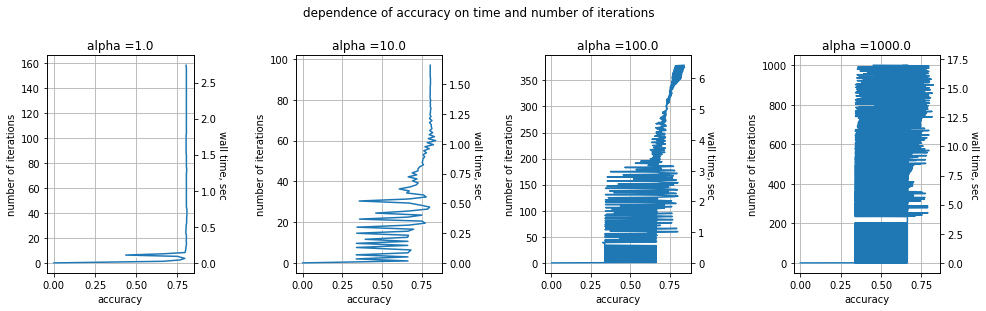

In [401]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.5)

fig.suptitle('dependence of accuracy on time and number of iterations', y=1.05)
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['acc'], np.arange(len(hist_list[i]['acc'])), c='w')
    axes1.set_title('alpha =' + '%.1f' % alpha_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('number of iterations')
    axes1.grid(True)
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['acc'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    num += 1
plt.savefig('alpha_time_acc.pdf', bbox_inches='tight')

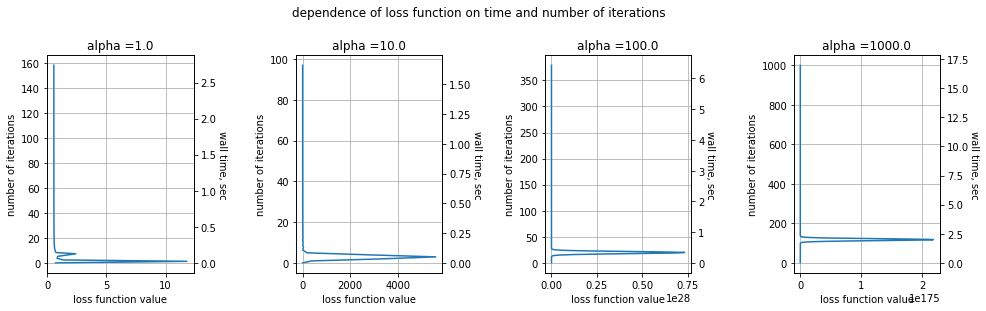

In [402]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function on time and number of iterations', y=1.05)
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'], np.arange(len(hist_list[i]['func'])), c='w')
    axes1.set_title('alpha =' + '%.1f' % alpha_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of iterations')
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('alpha_time_func_1.pdf', bbox_inches='tight')

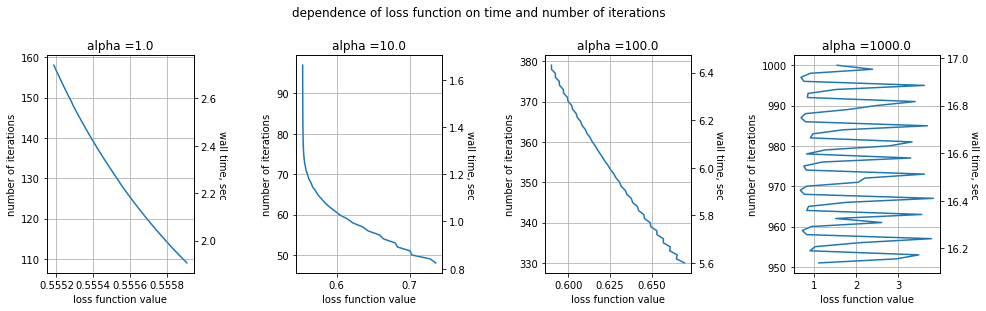

In [403]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function on time and number of iterations', y=1.05)
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'][-50:], np.arange(len(hist_list[i]['func'][-50:])) + 
               len(hist_list[i]['func']) - 50, c='w')
    axes1.set_title('alpha =' + '%.1f' % alpha_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of iterations')
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'][-50:], hist_list[i]['time'][-50:])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('alpha_time_func_2.pdf', bbox_inches='tight')

In [404]:
final_acc_list

[0.8031496062992126,
 0.8031496062992126,
 0.8393700787401575,
 0.4519685039370079]

Зависимость от начального приближения (???)

98
0.8031496062992126


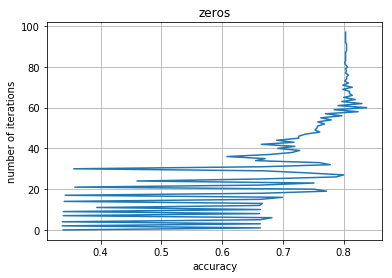

In [49]:
w_0 = np.zeros(np.size(x_train_bin, 1))
lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=1.30, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, w_0=w_0, trace=True)
plt.plot(hist['acc'], np.arange(len(hist['acc'])))
plt.grid(True)
plt.xlabel('accuracy')
plt.ylabel('number of iterations')
plt.title('zeros')
print(len(hist['acc']))
print(hist['acc'][-1])
plt.savefig('w0_1.pdf')

98
0.8031496062992126


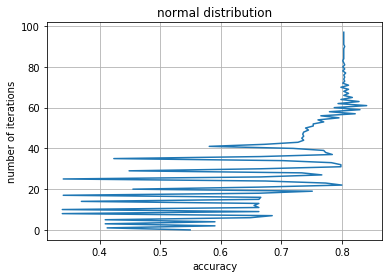

In [50]:
w_0 = np.random.randn(np.size(x_train_bin, 1))
lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=1.30, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, w_0=w_0, trace=True)
plt.plot(hist['acc'], np.arange(len(hist['acc'])))
plt.grid(True)
plt.xlabel('accuracy')
plt.ylabel('number of iterations')
plt.title('normal distribution')
print(len(hist['acc']))
print(hist['acc'][-1])
plt.savefig('w0_2.pdf')

97
0.8031496062992126


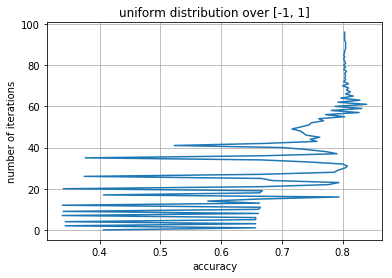

In [51]:
w_0 = np.random.uniform(-1, 1, np.size(x_train_bin, 1))
lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=1.30, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, w_0=w_0, trace=True)
plt.plot(hist['acc'], np.arange(len(hist['acc'])))
plt.grid(True)
plt.xlabel('accuracy')
plt.ylabel('number of iterations')
plt.title('uniform distribution over [-1, 1]')
print(len(hist['acc']))
print(hist['acc'][-1])
plt.savefig('w0_3.pdf')

98
0.8031496062992126


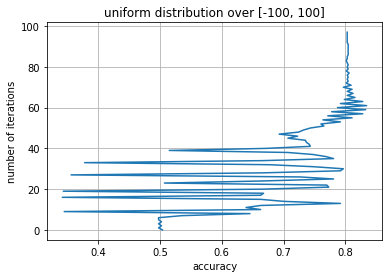

In [57]:
w_0 = np.random.uniform(-100, 100, np.size(x_train_bin, 1))
lr = GDClassifier(loss_function='binary_logistic', step_alpha=10, step_beta=1.30, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, w_0=w_0, trace=True)
plt.plot(hist['acc'], np.arange(len(hist['acc'])))
plt.grid(True)
plt.xlabel('accuracy')
plt.ylabel('number of iterations')
plt.title('uniform distribution over [-100, 100]')
print(len(hist['acc']))
print(hist['acc'][-1])
plt.savefig('w0_4.pdf')

Стохастическая регрессия

In [56]:
batch_list = [2 ** x for x in range(3, 9)]
hist_list=[]
final_acc_list = []

for batch in batch_list:
    lr = SGDClassifier(loss_function='binary_logistic', batch_size=batch, step_alpha=10, step_beta=1.3, 
                       max_iter=100000, tolerance=1e-6, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))
    final_acc_list.append(np.sum(np.equal(y_test_bin, lr.predict(x_test_bin))) / np.size(y_test_bin))

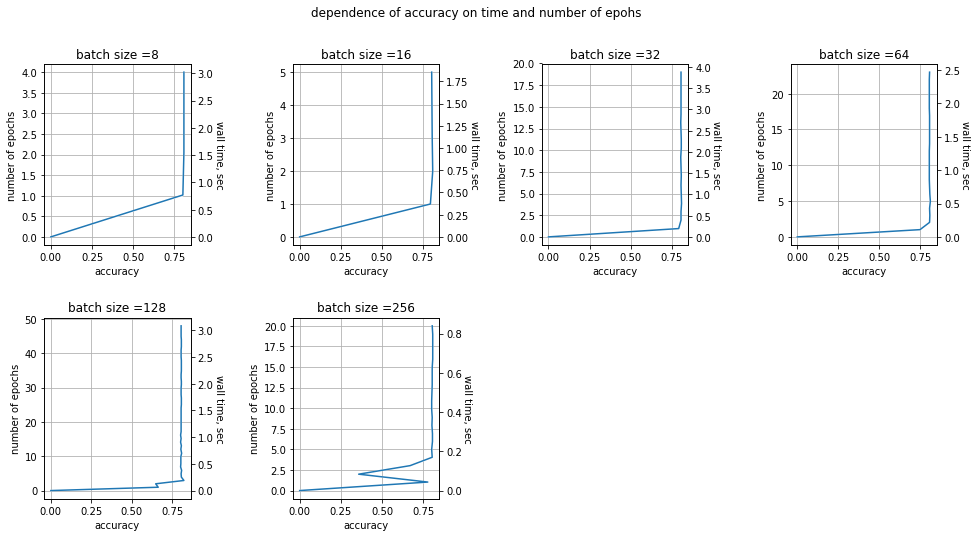

In [51]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of accuracy on time and number of epohs')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['acc'], np.arange(len(hist_list[i]['acc'])), c='w')
    axes1.set_title('batch size =' + '%.0f' % batch_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('number of epochs')
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['acc'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_acc.pdf', bbox_inches='tight')

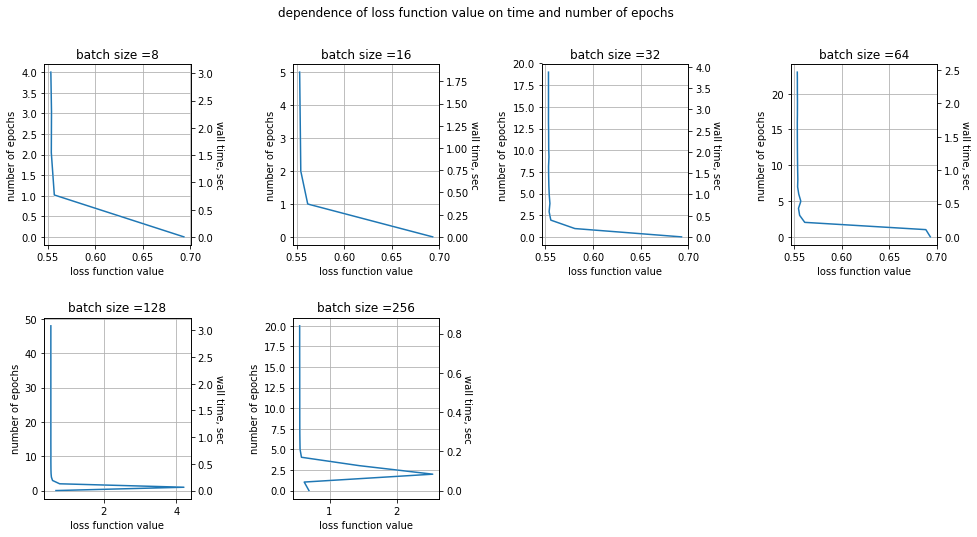

In [52]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function value on time and number of epochs')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'], np.arange(len(hist_list[i]['func'])), c='w')
    axes1.set_title('batch size =' + '%.0f' % batch_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of epochs')
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_func_1.pdf', bbox_inches='tight')

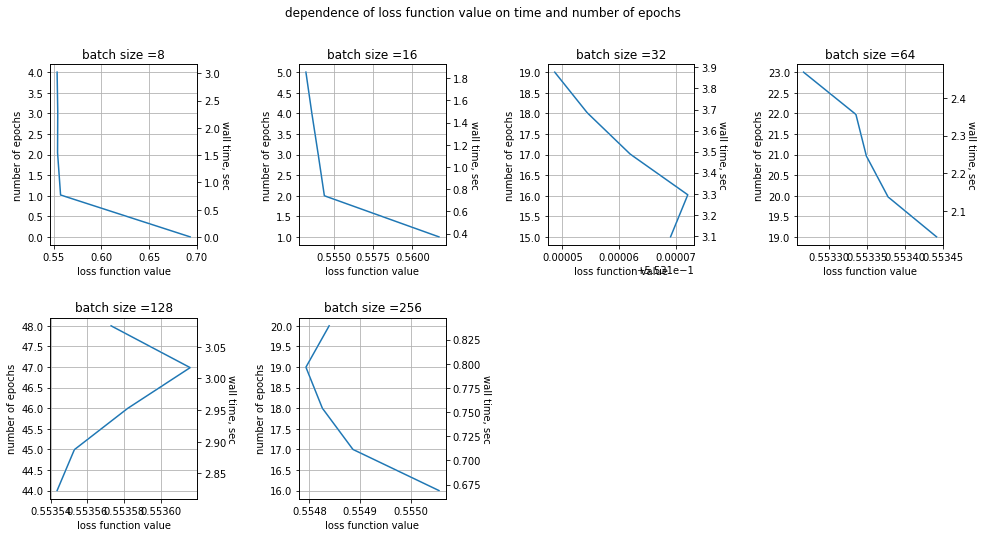

In [53]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function value on time and number of epochs')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'][-5:], np.arange(len(hist_list[i]['func'][-5:])) + \
                                max(len(hist_list[i]['acc']) - 5, 0), c='w')
    axes1.set_title('batch size =' + '%.0f' % batch_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of epochs')
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'][-5:], hist_list[i]['time'][-5:])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_func_2.pdf', bbox_inches='tight')

In [54]:
for i in range(len(hist_list)):
    print(hist_list[i]['acc'][-1])

0.8078740157480315
0.8047244094488188
0.8062992125984252
0.8062992125984252
0.8062992125984252
0.8031496062992126


In [57]:
lr = SGDClassifier(loss_function='binary_logistic', batch_size=1, step_alpha=10, step_beta=1.3, 
                       max_iter=100000, tolerance=1e-7, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True)

0.8047244094488188


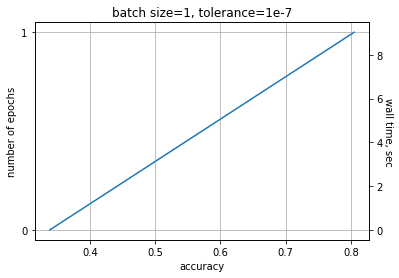

In [142]:
fig, axes1 = plt.subplots()
axes1.plot(hist['acc'], hist['epoch_num'], c='w')
axes1.grid()
axes1.set_xlabel('accuracy')
axes1.set_ylabel('number of epochs')
axes1.set_title('batch size=1, tolerance=1e-7')
axes1.set_yticks([0, 1])
axes2 = axes1.twinx()
axes2.plot(hist['acc'], hist['time'])
axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
plt.savefig('batch1_acc_1.pdf', bbox_inches='tight')
print(hist['acc'][-1])

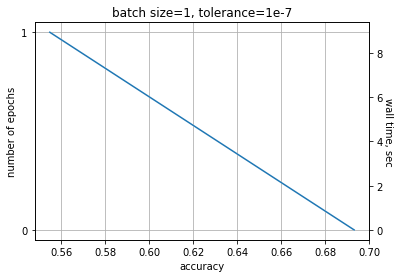

In [152]:
fig, axes1 = plt.subplots()
axes1.plot(hist['func'], hist['epoch_num'], c='w')
axes1.grid()
axes1.set_xlabel('accuracy')
axes1.set_ylabel('number of epochs')
axes1.set_title('batch size=1, tolerance=1e-7')
axes1.set_yticks([0, 1])
axes2 = axes1.twinx()
axes2.plot(hist['func'], hist['time'])
axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
plt.savefig('batch1_func_1.pdf', bbox_inches='tight')

In [136]:
lr = SGDClassifier(loss_function='binary_logistic', batch_size=1, step_alpha=10, step_beta=1.3, 
                       max_iter=100000, tolerance=1e-8, l2_coef=1)
hist = lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True)

0.8015748031496063


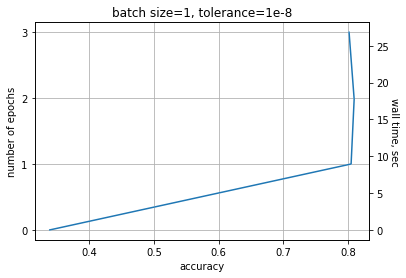

In [137]:
fig, axes1 = plt.subplots()
axes1.plot(hist['acc'], hist['epoch_num'], c='w')
axes1.grid()
axes1.set_xlabel('accuracy')
axes1.set_ylabel('number of epochs')
axes1.set_title('batch size=1, tolerance=1e-8')
axes1.set_yticks([x for x in range(0, 4)])
axes2 = axes1.twinx()
axes2.plot(hist['acc'], hist['time'])
axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
plt.savefig('batch1_acc_2.pdf', bbox_inches='tight')
print(hist['acc'][-1])

0.8015748031496063


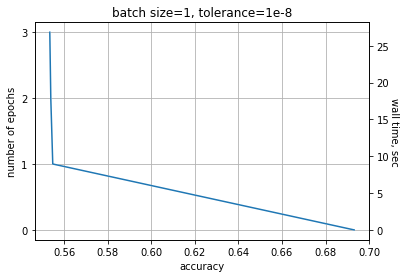

In [138]:
fig, axes1 = plt.subplots()
axes1.plot(hist['func'], hist['epoch_num'], c='w')
axes1.grid()
axes1.set_xlabel('accuracy')
axes1.set_ylabel('number of epochs')
axes1.set_title('batch size=1, tolerance=1e-8')
axes1.set_yticks([x for x in range(0, 4)])
axes2 = axes1.twinx()
axes2.plot(hist['func'], hist['time'])
axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
plt.savefig('batch1_func_2.pdf', bbox_inches='tight')
print(hist['acc'][-1])

beta

In [181]:
beta_list = [0.1 * x for x in range(6, 14)]
hist_list=[]

for beta in beta_list:
    lr = SGDClassifier(loss_function='binary_logistic', batch_size=32, step_alpha=10, step_beta=beta, 
                       max_iter=100000, tolerance=1e-6, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))

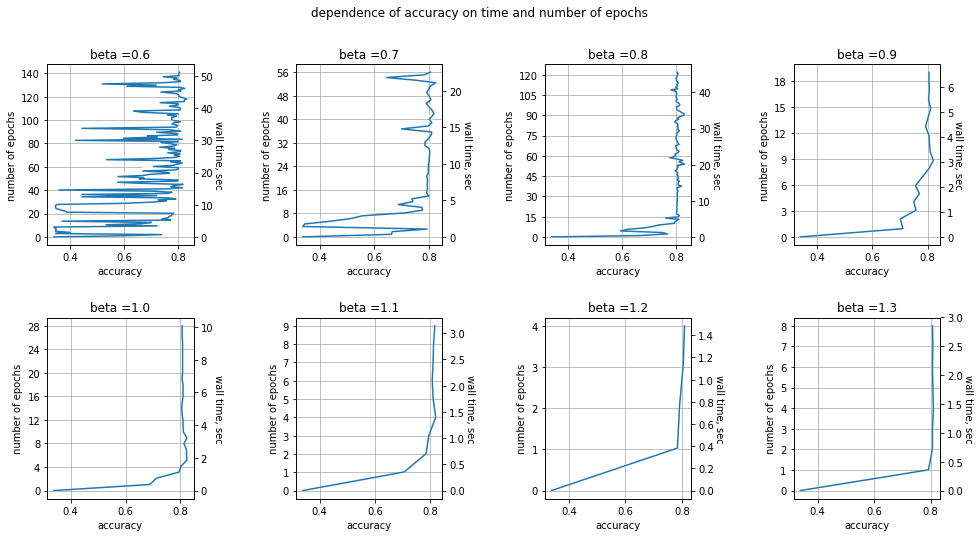

In [202]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of accuracy on time and number of epochs')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['acc'], np.arange(len(hist_list[i]['acc'])), c='w')
    axes1.set_title('beta =' + '%.1f' % beta_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('number of epochs')
    axes1.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['acc'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_beta_acc.pdf', bbox_inches='tight')

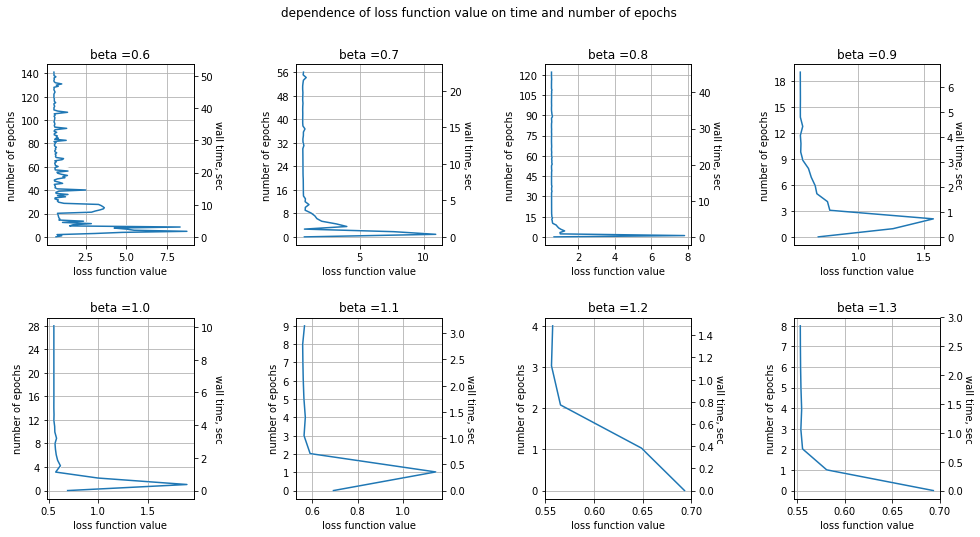

In [204]:
num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)


fig.suptitle('dependence of loss function value on time and number of epochs')
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'], np.arange(len(hist_list[i]['func'])), c='w')
    axes1.set_title('beta =' + '%.1f' % beta_list[i])
    axes1.set_xlabel('loss function value')
    axes1.set_ylabel('number of epochs')
    axes1.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_beta_func_1.pdf', bbox_inches='tight')

In [210]:
for i in range(len(hist_list)):
    print(hist_list[i]['acc'][-1])

0.8047244094488188
0.8047244094488188
0.8047244094488188
0.8047244094488188
0.8062992125984252
0.815748031496063
0.8094488188976378
0.8062992125984252


alpha

In [65]:
alpha_list = [10 ** x for x in range(0, 4)]
hist_list=[]

for alpha in alpha_list:
    lr = SGDClassifier(loss_function='binary_logistic', batch_size=32, step_alpha=alpha, step_beta=1.3, 
                       max_iter=100000, tolerance=1e-6, l2_coef=1)
    hist_list.append(lr.fit(x_train_bin, y_train_bin, x_test_bin, y_test_bin, trace=True))

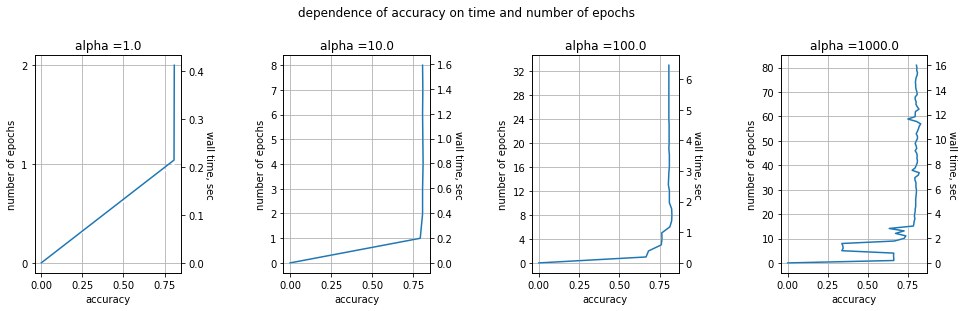

In [71]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of accuracy on time and number of epochs', y=1.05)
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['acc'], np.arange(len(hist_list[i]['acc'])), c='w')
    axes1.set_title('alpha =' + '%.1f' % alpha_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('number of epochs')
    axes1.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['acc'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_alpha_acc.pdf', bbox_inches='tight')

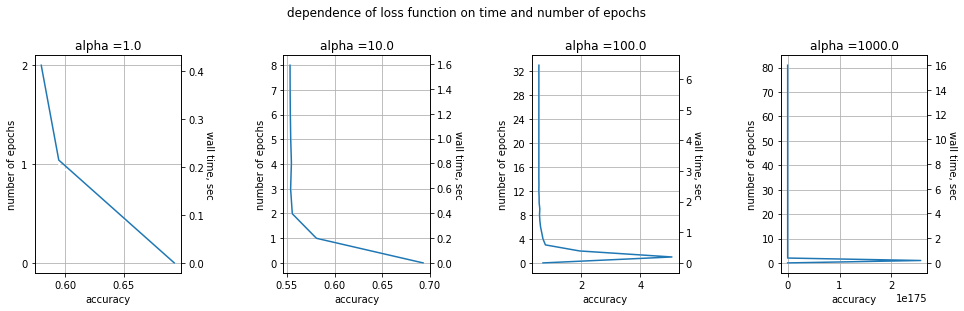

In [72]:
import matplotlib.pyplot as plt

num_plots = len(hist_list)
ncol, nrow = 4, num_plots // 4 + (num_plots % 4 > 0)
fig=plt.figure(figsize=(ncol * 4, nrow * 4))
plt.subplots_adjust(wspace=0.7, hspace=0.4)

fig.suptitle('dependence of loss function on time and number of epochs', y=1.05)
num = 1
for i in range(len(hist_list)):
    axes1 = plt.subplot(nrow, ncol, num)
    axes1.plot(hist_list[i]['func'], np.arange(len(hist_list[i]['func'])), c='w')
    axes1.set_title('alpha =' + '%.1f' % alpha_list[i])
    axes1.set_xlabel('accuracy')
    axes1.set_ylabel('number of epochs')
    axes1.yaxis.set_major_locator(MaxNLocator(integer=True))
    axes2 = axes1.twinx()
    axes2.plot(hist_list[i]['func'], hist_list[i]['time'])
    axes2.set_ylabel('wall time, sec', rotation=270, labelpad=10)
    axes1.grid(True)
    num += 1
plt.savefig('batch_alpha_func.pdf', bbox_inches='tight')

In [69]:
hist_list[2]['acc'][-1]

0.8062992125984252

multiclass

In [10]:
y_train_mult = np.zeros(y_train.shape)
neg_matr = y_train == 'negative'
y_train_mult[neg_matr] = 0
neutral_matr = y_train == 'neutral'
y_train_mult[neutral_matr] = 1
pos_matr = y_train == 'positive'
y_train_mult[pos_matr] = 2

y_test_mult = np.zeros(y_test.shape)
neg_matr = y_test == 'negative'
y_test_mult[neg_matr] = 0
neutral_matr = y_test == 'neutral'
y_test_mult[neutral_matr] = 1
pos_matr = y_test == 'positive'
y_test_mult[pos_matr] = 2

In [18]:
vectorizer = CountVectorizer()
x_train_mult = vectorizer.fit_transform(x_train)
x_test_mult = vectorizer.transform(x_test)

In [42]:
bin_lr = GDClassifier
args_dict = dict()
args_dict['loss_function'] = 'binary_logistic'
args_dict['max_iter'] = 1000
args_dict['step_alpha'] = 10
args_dict['step_beta'] = 1.3
args_dict['l2_coef'] = 1
start = time.time()
lr = MulticlassStrategy(classifier=bin_lr, mode='all_vs_all', **args_dict)
lr.fit(x_train_mult, y_train_mult)
y_pred = lr.predict(x_test_mult)
print('all vs all', np.sum(np.equal(y_pred, y_test_mult)) / np.size(y_test_mult))
end = time.time()
print('wall time, sec:', end - start)
start = time.time()
lr = MulticlassStrategy(classifier=bin_lr, mode='one_vs_all', **args_dict)
lr.fit(x_train_mult, y_train_mult)
y_pred = lr.predict(x_test_mult)
print('one vs all', np.sum(np.equal(y_pred, y_test_mult)) / np.size(y_test_mult))
end = time.time()
print('wall time, sec:', end - start)

all vs all 0.6387096774193548
one vs all 0.6411290322580645


In [19]:
start = time.time()
lr = GDClassifier(loss_function='multinomial_logistic', step_alpha=10, step_beta=1.3, l2_coef=1)
lr.fit(x_train_mult, y_train_mult)
y_pred = lr.predict(x_test_mult)
print('multinomial', np.sum(np.equal(y_pred, y_test_mult)) / np.size(y_test_mult))
end = time.time()
print('wall time, sec', end - start)

multinomial 0.6443548387096775


Предобработка текста

In [11]:
import pymorphy2
lemmatizer = pymorphy2.MorphAnalyzer()

In [12]:
x_train_lem = list()
for i in range(np.size(x_train, 0)):
    tokenizer = x_train[i].split()
    x_train_lem.append(" ".join([lemmatizer.parse(word)[0].normal_form for word in tokenizer]))

In [14]:
x_test_lem = list()
for i in range(np.size(x_test, 0)):
    tokenizer = x_test[i].split()
    x_test_lem.append(" ".join([lemmatizer.parse(word)[0].normal_form for word in tokenizer]))

In [15]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/daria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
filt_x_train_lem = list()
for text in x_train_lem:
    tokenizer = text.split()
    filt_x_train_lem.append(" ".join([word for word in tokenizer if word not in stopwords.words('russian')]))
       

In [17]:
filt_x_test_lem = list()
for text in x_test_lem:
    tokenizer = text.split()
    filt_x_test_lem.append(" ".join([word for word in tokenizer if word not in stopwords.words('russian')]))

In [18]:
import pickle

with open('train.txt', 'wb') as fp:
    pickle.dump(filt_x_train_lem, fp)
fp.close()
    
with open('test.txt', 'wb') as fp:
    pickle.dump(filt_x_test_lem, fp)
fp.close()

In [ ]:
import pickle

with open('train.txt', 'rb') as fp:
    filt_x_train_lem = pickle.load(fp)
    
with open('test.txt', 'rb') as fp:
    filt_x_test_lem = pickle.load(fp)

In [44]:
vectorizer = CountVectorizer()
x_train_mult = vectorizer.fit_transform(filt_x_train_lem)
x_test_mult = vectorizer.transform(filt_x_test_lem)

In [27]:
x_train_mult.shape

(7023, 56532)

In [29]:
start = time.time()
lr = GDClassifier(loss_function='multinomial_logistic', step_alpha=10, step_beta=1.3, l2_coef=1)
lr.fit(x_train_mult, y_train_mult)
y_pred = lr.predict(x_test_mult)
print('multinomial', np.sum(np.equal(y_pred, y_test_mult)) / np.size(y_test_mult))
end = time.time()
print('wall time, sec:', end - start)

multinomial 0.6709677419354839
wall time, sec: 309.85294699668884


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
x_train_mult = vectorizer.fit_transform(filt_x_train_lem)
x_test_mult = vectorizer.transform(filt_x_test_lem)

In [ ]:
start = time.time()
lr = GDClassifier(loss_function='multinomial_logistic', step_alpha=1, step_beta=0.1,
                  tolerance=1e-4, l2_coef=0.001)
hist = lr.fit(x_train_mult, y_train_mult, x_test_mult, y_test_mult, trace=True)
y_pred = lr.predict(x_test_mult)
print('multinomial', np.sum(np.equal(y_pred, y_test_mult)) / np.size(y_test_mult))
end = time.time()
print('wall time, sec:', end - start)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_mult, y_pred)

In [ ]:
mask_2 = y_pred == 2
mask_0 = y_test_mult == 0
mask = np.logical_and(mask_2, mask_0)
print(np.sum(mask))
print(x_test[mask][7])

In [26]:
x_train_mult.shape

(7023, 56532)